<a href="https://colab.research.google.com/github/AlbertoRomanRamosRodriguez/Tesis-de-Grado/blob/main/aptos_eyepacs_vgg_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grading Diabetic Retinopath with APTOS and EYEPACS using ResNet 50

In [2]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive,move
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
class KaggleJSONFile:
  def __init__(self, folder_path:str):
    self.__folder_location = folder_path
    self.__filename = 'kaggle.json'
    self.__destination_path = '/root/.kaggle'

  def setup(self):
    p_orig = os.path.join(self.__folder_location, self.__filename)
    p_dest = os.path.join(self.__destination_path, self.__filename)

    os.mkdir(self.__destination_path)
    copy(p_orig, p_dest)

    !chmod 600 {p_dest}


In [6]:
k = KaggleJSONFile('/gdrive/MyDrive/Kaggle_keys')
k.setup()

In [7]:
!kaggle competitions download -c aptos2019-blindness-detection
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

100% 9.51G/9.51G [05:53<00:00, 31.7MB/s]
100% 9.51G/9.51G [05:53<00:00, 28.9MB/s]
100% 6.04G/6.04G [03:09<00:00, 36.4MB/s]
100% 6.04G/6.04G [03:09<00:00, 34.2MB/s]


In [8]:
zipfiles = [f for f in os.listdir('/content') if '.zip' in f]

def unpack(filename:str):
  f = os.path.join('/content', filename)

  unpack_archive(
      filename = f,
      extract_dir='/content'
  )

  return os.path.join('/content',filename.split('.')[0])

dataset_dirs = [unpack(z) for z in zipfiles]

In [9]:
aptos_csv = '/content/train.csv'
eyepacs_csv = '/content/trainLabels.csv'
dataframes = [pd.read_csv(csv) for csv in [aptos_csv, eyepacs_csv]]

name_mappings = {
    'id_code': 'image',
    'diagnosis': 'level'
}


for d, extension in zip(dataframes, ['.png', '.jpeg']):
  d.rename(columns=name_mappings, inplace=True)
  d['image'] = d['image']+ extension
  display(d.head())

bd_names = ('APTOS 19', 'EYEPACS')

classes = range(5)
orig_ds = pd.concat([dfn.assign(DB=bdn) for dfn, bdn in zip(dataframes, bd_names)])
orig_ds.reset_index(inplace=True)
orig_ds.drop(columns=['index'], inplace=True)
orig_ds

,image,level
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


,image,level,DB
0,000c1434d8d7.png,2,APTOS 19
1,001639a390f0.png,4,APTOS 19
2,0024cdab0c1e.png,1,APTOS 19
3,002c21358ce6.png,0,APTOS 19
4,005b95c28852.png,0,APTOS 19
...,...,...,...
38765,44347_right.jpeg,0,EYEPACS
38766,44348_left.jpeg,0,EYEPACS
38767,44348_right.jpeg,0,EYEPACS
38768,44349_left.jpeg,0,EYEPACS


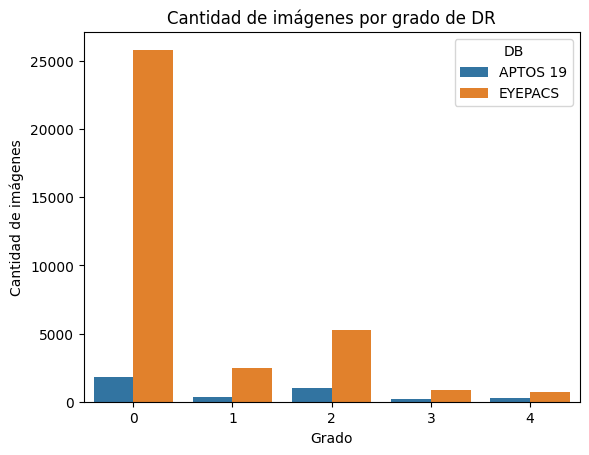

In [10]:
# Create the bar plot
sns.countplot(x='level', data=orig_ds, hue='DB')

# Set the plot title and axis labels
plt.title('Cantidad de imágenes por grado de DR')
plt.xlabel('Grado')
plt.ylabel('Cantidad de imágenes')

# Show the plot
plt.savefig('distribution.jpg')
plt.show()

level
0    27607
1     2808
2     6287
3     1065
4     1003
Name: image, dtype: int64

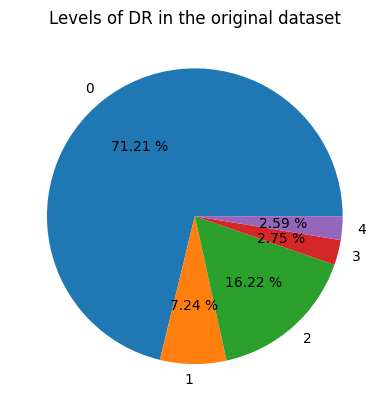

In [11]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

DB_PATH = './DB'
reset_path(DB_PATH)

display(orig_ds.groupby('level')['image'].count())

classes = 5
plt.pie([orig_ds.loc[orig_ds['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the original dataset")
img_path = os.path.sep.join([DB_PATH, 'distribution-pie.jpg'])
plt.savefig(img_path)
plt.show()

level
0    1000
1    1000
2    1000
3    1000
4    1000
Name: image, dtype: int64

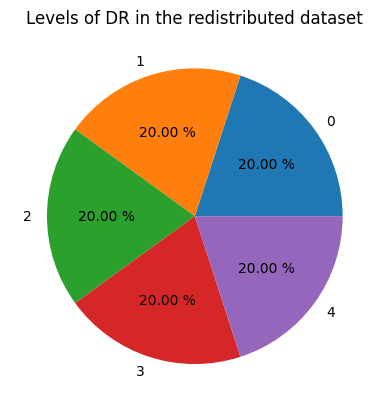

In [12]:
dataset = orig_ds.groupby(['level']).sample(1000)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the redistributed dataset")
plt.show()

In [13]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

display(train_df.groupby(['level'])['image'].count())
display(train_df.head())
display(val_df.groupby(['level'])['image'].count())
display(val_df.head())
display(test_df.groupby(['level'])['image'].count())
display(test_df.head())

level
0    784
1    810
2    808
3    790
4    808
Name: image, dtype: int64

,image,level
29940,33283_right.jpeg,4
1060,4bd941611343.png,4
28418,31326_left.jpeg,0
624,2bbd1f99ecc3.png,3
6525,3563_left.jpeg,4


level
0    108
1     96
2     96
3    103
4     97
Name: image, dtype: int64

,image,level
34765,39344_right.jpeg,2
29508,32726_right.jpeg,3
11110,9376_left.jpeg,2
35532,40284_left.jpeg,1
8697,6348_right.jpeg,0


level
0    108
1     94
2     96
3    107
4     95
Name: image, dtype: int64

,image,level
36552,41566_left.jpeg,3
3525,f57cf3b6f48e.png,0
12571,11187_left.jpeg,2
23183,24668_right.jpeg,1
27980,30747_left.jpeg,3


In [14]:
path_dict = {p:os.listdir(p)
              for p in ['/content/train_images', '/content/eyepacs_preprocess/eyepacs_preprocess']}
path_dict

{'/content/train_images': ['3402124408ea.png',
  'b7aca95b97b9.png',
  '0f495d87656a.png',
  'a688f20f8895.png',
  '7bc4dd99eee5.png',
  'd1ca85af57c9.png',
  '51d780864365.png',
  '10f36b0239fb.png',
  'dccdf750c962.png',
  'ff4832d55461.png',
  'e540d2e35d15.png',
  '91f3c4c1e72b.png',
  '6165081b9021.png',
  'cd8da43e3069.png',
  '8f2996b8d855.png',
  'eb1ad14dd281.png',
  '956765d5f46d.png',
  '65e51e18242b.png',
  'ca0f1a17c8e5.png',
  '8a8a251770cd.png',
  '5eb311bcb5f9.png',
  'c0a117de7d0a.png',
  'f025f33b2c9b.png',
  '2af1bf226f51.png',
  '9a94e0316ee3.png',
  'd6df4fe492ec.png',
  '6f4719c6bb4b.png',
  '1c4f3aa4df06.png',
  '94ef1d14597f.png',
  'a5bb85afc6e8.png',
  'f23902998c21.png',
  'aa6242f9e08c.png',
  '9b70f84400af.png',
  'c24bcf7a1bc4.png',
  '0423237770a7.png',
  '54dc6e8107cd.png',
  'ef8c39eb9157.png',
  '91e8af9ceee9.png',
  'a8e88d4891c4.png',
  '576e189d23d4.png',
  '186c1835eec5.png',
  '891329021e12.png',
  'dcf109df1a2b.png',
  '9122b31414d3.png',
  '67f5

In [15]:
def clahe_image(path:str):
    # Load the image
    img = cv2.imread(path)
    # mask = cv2.imread('mask.png', 0)

    # Extract the green plane
    green_plane = img[:, :, 1]

    # Define the FA-CLAHE algorithm
    faclahe = cv2.createCLAHE(clipLimit=4.5, tileGridSize=(22, 22))

    # Apply the FA-CLAHE algorithm to the green plane
    faclahe_img = faclahe.apply(green_plane)

    # masked_img = cv2.bitwise_and(faclahe_img, faclahe_img, mask=mask)

    cv2.imwrite(path, faclahe_img)

In [16]:
from shutil import copy
import cv2

splits = [
    (train_df, 'train'),
    (val_df, 'val'),
    (test_df, 'test')
]

for df, set_path in splits:
  df['level'] = df['level'].astype('str')
  ds_dict = df.to_dict(orient='index')
  set_path = os.path.join(DB_PATH, set_path)
  if not os.path.exists(set_path):
    os.mkdir(set_path)

  for datapoint in ds_dict.values():
    orig_path = ''
    for p, imgs in path_dict.items():
        orig_path = os.path.join(p, datapoint['image']) if datapoint['image'] in imgs else orig_path

    if orig_path == '':
      raise ValueError
    dest_path = os.path.join(set_path, datapoint['level'])
    
    if not os.path.exists(dest_path):
      os.mkdir(dest_path)
    
    dest_path = os.path.join(dest_path, datapoint['image'])

    move(orig_path, dest_path)
    clahe_image(dest_path)

    print(f'Copied {dest_path}')

Copied ./DB/train/4/33283_right.jpeg
Copied ./DB/train/4/4bd941611343.png
Copied ./DB/train/0/31326_left.jpeg
Copied ./DB/train/3/2bbd1f99ecc3.png
Copied ./DB/train/4/3563_left.jpeg
Copied ./DB/train/2/986_right.jpeg
Copied ./DB/train/4/85cbb84ac8e0.png
Copied ./DB/train/4/11417_right.jpeg
Copied ./DB/train/2/42457_left.jpeg
Copied ./DB/train/2/30884_left.jpeg
Copied ./DB/train/3/8749_right.jpeg
Copied ./DB/train/1/28080_left.jpeg
Copied ./DB/train/3/38247_right.jpeg
Copied ./DB/train/3/4360a112db10.png
Copied ./DB/train/2/4421_left.jpeg
Copied ./DB/train/2/508_right.jpeg
Copied ./DB/train/0/493d99f030e2.png
Copied ./DB/train/4/21d18b022429.png
Copied ./DB/train/3/15056_left.jpeg
Copied ./DB/train/4/13588_right.jpeg
Copied ./DB/train/4/41584_left.jpeg
Copied ./DB/train/4/40917_left.jpeg
Copied ./DB/train/0/43657_left.jpeg
Copied ./DB/train/4/b55d2ddb3e75.png
Copied ./DB/train/1/30081_right.jpeg
Copied ./DB/train/1/26996_right.jpeg
Copied ./DB/train/2/2648_right.jpeg
Copied ./DB/train/4

In [17]:
# ResNet Grading of Diabetic Retinopathy in PyTorch
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

## Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, starting_loss = float('inf'), warmup_epochs = 0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = starting_loss
    best_acc = 0.0 
    
    total_epochs = num_epochs+warmup_epochs
    try:
        for epoch in range(total_epochs):
            print(f'Epoch {epoch+1}/{total_epochs}')
            
            if warmup_epochs != 0 and epoch == (warmup_epochs - 1):
                for param in model_ft.parameters():
                    param.requires_grad = True
                print(f"Starting full training")
            elif warmup_epochs != 0 and epoch <= (warmup_epochs - 1):
                print(f"{warmup_epochs-epoch+1} warmup epochs remaining")
            elif warmup_epochs != 0 and epoch == 0:
                print(f"Starting warmup training")
            elif epoch == 0:
                print("Training without warmup")
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Update best validation loss and model weights
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best model found with validation loss: {best_loss:.4f}')

            print()

    except KeyboardInterrupt:
        pass

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_loss:.4f} | Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return (best_loss, model)




def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
#     if not os.path.exists('')

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                
                if not os.path.exists(os.path.join('output', 'prediction_examples')):
                    os.mkdir(os.path.join('output', 'prediction_examples'))
                path = os.path.join('output', 'prediction_examples',f'test_image-{j}.jpg')
                plt.savefig(path)
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


Using device cuda


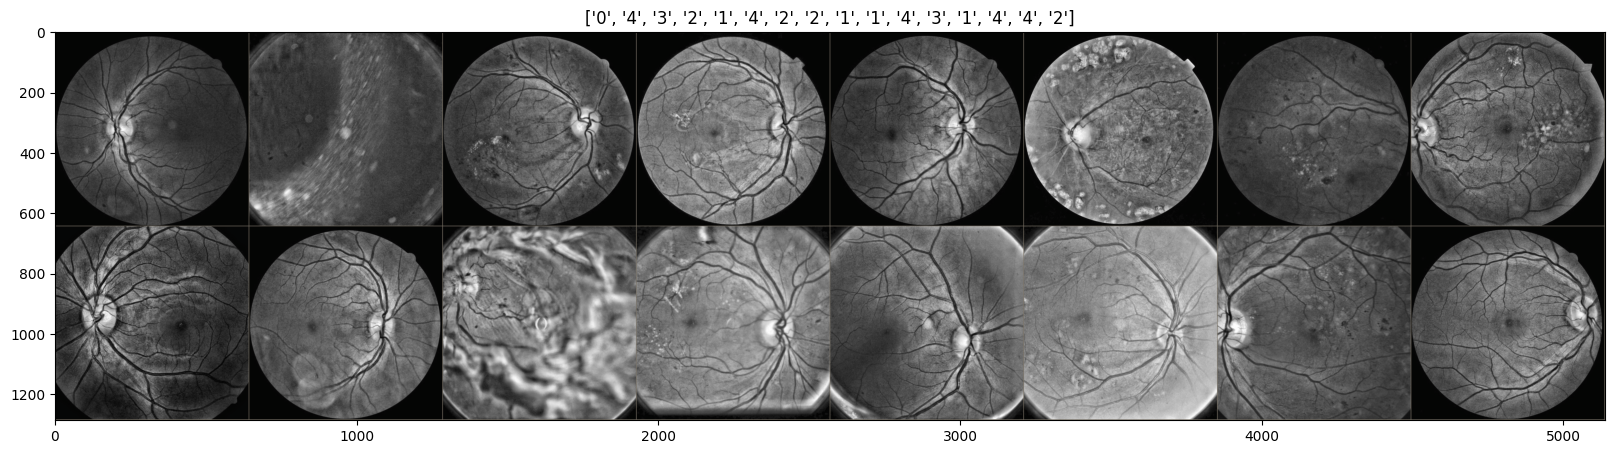

In [18]:
## Load Data
IM_SIZE = 640
batch_size = 16
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                        shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                        shuffle=False, num_workers=2)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device {device}')

def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
#     plt.savefig('batch.jpg')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))

In [20]:
import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')
model_weights = models.VGG16_Weights.DEFAULT

model_ft = models.vgg16(weights=model_weights)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 5)
model_ft = nn.DataParallel(model_ft)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(
    model_ft.parameters(), 
    lr=0.01, 
    weight_decay=1e-5, 
    momentum=0.9
)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [21]:
warmup_epochs = 7
training_epochs = 25

print(f"Training on device {device}")
# for param in model_ft.parameters():
#     param.requires_grad = False

best_train_loss, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs = training_epochs,
    warmup_epochs = warmup_epochs
    
)

Training on device cuda
Epoch 1/32
8 warmup epochs remaining
----------
train Loss: 2.8993 Acc: 0.3158
val Loss: 2.8290 Acc: 0.3600
New best model found with validation loss: 2.8290

Epoch 2/32
7 warmup epochs remaining
----------
train Loss: 3.7352 Acc: 0.3362
val Loss: 2.9431 Acc: 0.3820

Epoch 3/32
6 warmup epochs remaining
----------
train Loss: 3.6247 Acc: 0.3588
val Loss: 2.2741 Acc: 0.4000
New best model found with validation loss: 2.2741

Epoch 4/32
5 warmup epochs remaining
----------
train Loss: 3.9183 Acc: 0.3350
val Loss: 2.8255 Acc: 0.3600

Epoch 5/32
4 warmup epochs remaining
----------
train Loss: 3.9224 Acc: 0.3503
val Loss: 2.2928 Acc: 0.4380

Epoch 6/32
3 warmup epochs remaining
----------
train Loss: 4.1677 Acc: 0.3508
val Loss: 2.6743 Acc: 0.3640

Epoch 7/32
Starting full training
----------
train Loss: nan Acc: 0.1965
val Loss: nan Acc: 0.2160

Epoch 8/32
----------
train Loss: nan Acc: 0.1960
val Loss: nan Acc: 0.2160

Epoch 9/32
----------
Training complete in 47

In [ ]:
if not os.path.exists('models'):
  os.mkdir('models')

FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_{best_train_loss}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')
MODEL_PATH = f'{FILENAME}.pt'
torch.save(model_ft.state_dict(), MODEL_PATH)

In [24]:
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

device = torch.device("cpu")
# model_ft = model_ft.to(device)
model_ft.eval()

for inputs, labels in test_dataloader:
        # inputs = inputs.to(device)
        # labels = labels.to(device)
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")

# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

if not os.path.exists('output'):
  os.mkdir('output')
OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

visualize_model(model_ft)
print("[INFO] Building Matrix")
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)

[INFO] Iterating predictions


RuntimeError: ignored